## Data for cats vs. dogs
- 2013년 Kaggle의 computer vision competition data 활용 https://www.kaggle.com/c/dogs-vs-cats/data
- 개와 고양이를 구분하기 위한 문제로 각 12,500개의 이미지를 포함
- Medium-resolution color JPEGs
- 25000장의 사진 중 4000장의 cats/dogs 사진(2000 cats, 2000 dogs) 만을 사용하여 학습하여 좋은 모형을 만들어 낼 수 있을까?
    - 2000 for training, 1000 for validation, 1000 for testing 
- `git pull` 실행 후 `data` folder에서 `unzip cats_and_dogs_small.zip -d ./cats_and_dogs_small` 명령어 실행하면 `cats_and dogs_small` 폴더에 데이터 압축이 해제됨
![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

## Build a network

- Input: $150 \times 150$ 픽셀의 RGB layer 
- Output: cat or dog (binary classification with sigmoid activation) 
- Hidden layers:  `Conv2D`(with `relu` activation) + `MaxPooling2D`

## Data preprocessing

- CNN 입력을 위한 이미지 전처리 단계 
    * 사진 파일 읽기
    * JPEG content를 RBG 픽셀 값으로 디코딩
    * floating point tensor 형태로 변환 
    * 0-255 사이의 값을 가지는 픽셀 값을 [0,1] 사이 값으로 변환

- `tensorflow.keras.preprocessing.image.ImageDataGenerator`를 사용하여 자동으로 입력 가능한 형태로 변환할 수 있음

In [35]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

### 데이터 로드 및 전처리

In [36]:
# train, validation, test 이미지가 들어있는 폴더 경로를 지정
train_dir = './data/cats_and_dogs_small/train'
validation_dir = './data/cats_and_dogs_small/validation'
test_dir = './data/cats_and_dogs_small/test'

### 훈련 데이터 전처리 및 증강

In [37]:
train_datagen = ImageDataGenerator(
    rescale=1./255,          # 픽셀 값을 0과 1 사이로 정규화
    shear_range=0.2,         # 이미지 기울이기
    zoom_range=0.2,          # 이미지 확대/축소
    horizontal_flip=True     # 수평 반전
)

# 검증 및 테스트 데이터 전처리
test_datagen = ImageDataGenerator(rescale=1./255)

# 훈련 데이터 생성
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # 이미지 크기 변경
    batch_size=32,
    class_mode='binary'      # 개와 고양이를 구별하므로 이진 분류
)

# 검증 데이터 생성
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

# 테스트 데이터 생성
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


- `train_generator`의 output
    - Batches of 150x150 RGB images (shape `(20, 150, 150, 3)`)
    - Binary labels (shape `(20,)`)
    - Batch size=20: the number of samples in each batch
- `ImageDataGenerator`는 이미지를 끝없이 생성하기 때문에 원하는 단계에서 `break`가 필요 

In [38]:
# 생성된 iterator로 batch 생성 후 확인
batch=next(train_generator)

In [39]:
# 2개의 요소를 가지는 tuple 형태가 생성됨
print(type(batch))
len(batch)

<class 'tuple'>


2

In [40]:
batch[0].shape # 생성된 tuple의 첫 번째 요소는 150*150*3의 이미지 20개

(32, 150, 150, 3)

In [41]:
batch[1] # 생성된 tuple의 두 번째 요소는 binary label

array([0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.],
      dtype=float32)

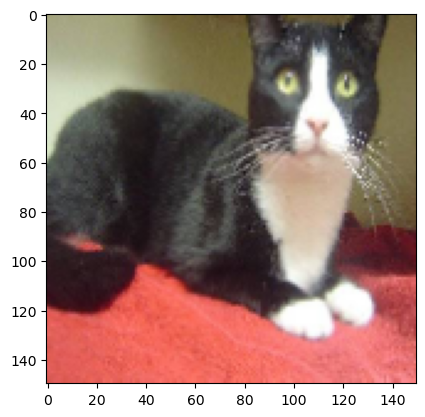

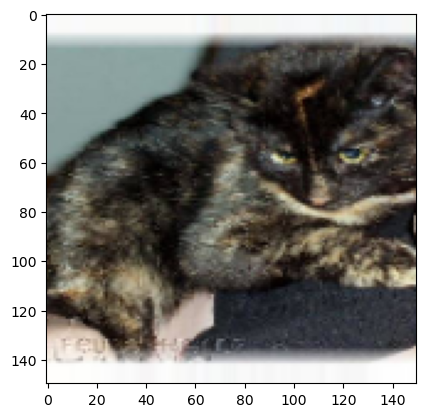

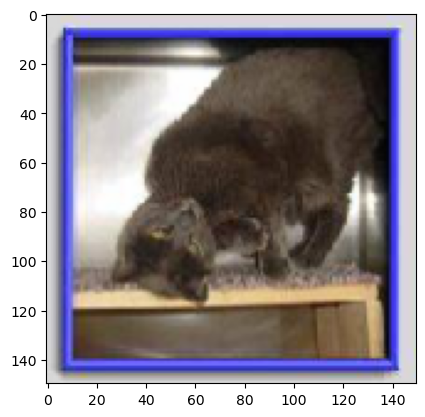

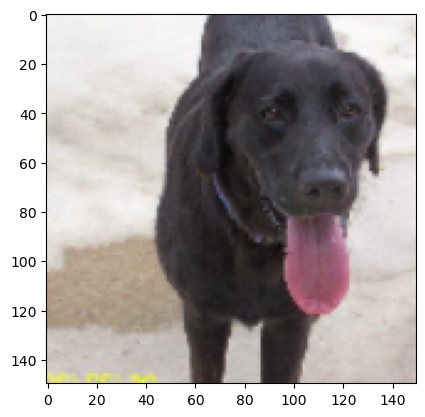

In [42]:
# 생성된 tuple의 이미지 확인 
for i in range(4):
    plt.figure(i)
    plt.imshow(batch[0][i])

In [43]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 150, 150, 3)
labels batch shape: (32,)


In [44]:
# CNN 모델 구축
model = models.Sequential([
    # 첫 번째 합성곱 층
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),

    # 두 번째 합성곱 층
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # 세 번째 합성곱 층
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # 네 번째 합성곱 층
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Flatten 층
    layers.Flatten(),

    # 완전 연결층
    layers.Dense(512, activation='relu'),
    
    # 출력층 (이진 분류)
    layers.Dense(1, activation='sigmoid')
])

# 모델 컴파일
model.compile(
    loss='binary_crossentropy',      # 이진 교차 엔트로피 손실 함수
    optimizer='adam',                # Adam 최적화 알고리즘
    metrics=['accuracy']             # 정확도 평가
)

# 모델 요약
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# 모델 훈련
history = model.fit(
    train_generator,
    steps_per_epoch=100,              # 한 에폭마다 훈련할 배치 수
    epochs=20,                        # 훈련할 에폭 수
    validation_data=validation_generator,
    validation_steps=50              # 검증할 배치 수
)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 172ms/step - accuracy: 0.4732 - loss: 0.7201 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 169ms/step - accuracy: 0.5251 - loss: 0.6926 - val_accuracy: 0.5690 - val_loss: 0.6861
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 168ms/step - accuracy: 0.5449 - loss: 0.6907 - val_accuracy: 0.5940 - val_loss: 0.6819
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 166ms/step - accuracy: 0.5670 - loss: 0.6836 - val_accuracy: 0.5180 - val_loss: 0.6830
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 167ms/step - accuracy: 0.5852 - loss: 0.6791 - val_accuracy: 0.6090 - val_loss: 0.6496
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 168ms/step - accuracy: 0.6038 - loss: 0.6567 - val_accuracy: 0.6390 - val_loss: 0.6250
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 168ms/step - accuracy: 0.6426 - loss: 0.6376 - val_accuracy: 0.6590 - val_loss: 0.6193
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 169ms/step - accuracy: 0.6461 - loss: 0

In [46]:
model.save('cats_and_dogs_small_1.h5')

In [47]:
# 테스트 데이터로 모델 평가
test_loss, test_acc = model.evaluate(test_generator, steps=50)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.7333 - loss: 0.5645
Test Accuracy: 73.30%


- Overfitting 발생 
    - Training accuracy는 계속 증가하지만 validation accuracy는 70-72%에서 움직임
    - Training sample이 2000개 

In [48]:
from keras.models import load_model

In [49]:
model=load_model('cats_and_dogs_small_1.h5')

### 모델 예측

In [50]:
# 예측 예시
import numpy as np
from tensorflow.keras.preprocessing import image

# 이미지 로드
img_path = 'figures/cat.jpg'
img = image.load_img(img_path, target_size=(150, 150))

# 이미지를 배열로 변환하고 정규화
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# 예측
prediction = model.predict(img_array)
print("Prediction:", "Cat" if prediction[0] < 0.5 else "Dog")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Prediction: Dog


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


C:\Users\admin\AppData\Local\Temp\ipykernel_9288\3882803969.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Prob(dog): %f'%(pred))


Prob(dog): 0.642743


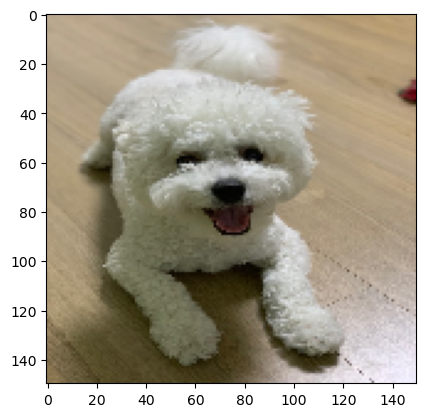

In [51]:
import matplotlib.pyplot as plt
img_path = 'figures/leo2.jpg'
img = image.load_img(img_path, target_size=(150, 150))
plt.imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.

pred=model.predict(x)
print('Prob(dog): %f'%(pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prob(dog): 0.649032


C:\Users\admin\AppData\Local\Temp\ipykernel_9288\4172941950.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Prob(dog): %f'%(pred))


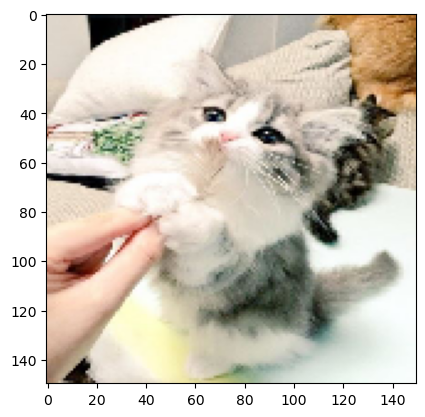

In [52]:
img_path = 'figures/cat.jpg'
img = image.load_img(img_path, target_size=(150, 150))
plt.imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.

pred=model.predict(x)
print('Prob(dog): %f'%(pred))